In [ ]:
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd
from pycatch22 import catch22_all

DATASET_PATH = Path("data/raw/")
test_paths = sorted(DATASET_PATH.rglob('*.out'))
train_paths = sorted(DATASET_PATH.rglob('*train*'))

EXCLUDE_DATASETS = [
    'ECG',
    'GHL',
    'IOPS',
    'MITDB',
]

# number of files
print(len(test_paths))

In [ ]:
# return true if a valid file
def is_valid(values: np.ndarray) -> bool:
    if not np.issubdtype(values.dtype, np.number): return False
    if np.isnan(values).any(): return False
    return True

def exclude(path: Path) -> bool:
    if path.parts[-2] in EXCLUDE_DATASETS: return True
    return False

def load_data(path: Path) -> tuple:
    values, labels = np.hsplit(pd.read_csv(test_path, header=None, names=['values', 'is_anomaly']).values, 2)
    return values.flatten(), labels.flatten()

valid_test_paths = []
with tqdm(test_paths, desc="loading", unit="file") as pbar:
    for test_path in pbar:
        test_values, test_labels = load_data(test_path)
        if exclude(test_path): continue
        if not is_valid(test_values): continue
        valid_test_paths.append(test_path)

In [ ]:
# invalid and excluded files
[p for p in test_paths if p not in valid_test_paths]

In [ ]:
rows = []
with tqdm(valid_test_paths, desc="processing", unit="file") as pbar:
    for test_path in pbar:
        dataset_name = test_path.parts[-2]
        file_name = test_path.name

        test_values, test_labels = np.hsplit(pd.read_csv(test_path, header=None, names=['values', 'is_anomaly']).values, 2)

        out = catch22_all(test_values, catch24=True)
        rows.append(dict(zip(['Path', 'Dataset', 'File'] + out['names'], [test_path, dataset_name, file_name] + out['values'])))
        pbar.set_postfix_str(f"file: {test_path.name}, length: {len(test_values)}")

embeddings_df = pd.DataFrame(rows)
embeddings_df

In [ ]:
if not Path('out.csv').exists():
    embeddings_df.to_csv('out.csv', index=False)

In [ ]:
pd.set_option('display.max_columns', 30)
embeddings_df

Index(['CO_f1ecac', 'CO_FirstMin_ac', 'CO_HistogramAMI_even_2_5',
       'CO_trev_1_num', 'MD_hrv_classic_pnn40',
       'SB_BinaryStats_mean_longstretch1',
       'SB_TransitionMatrix_3ac_sumdiagcov',
       'CO_Embed2_Dist_tau_d_expfit_meandiff',
       'IN_AutoMutualInfoStats_40_gaussian_fmmi',
       'FC_LocalSimple_mean1_tauresrat', 'DN_OutlierInclude_p_001_mdrmd',
       'DN_OutlierInclude_n_001_mdrmd', 'SP_Summaries_welch_rect_area_5_1',
       'SB_BinaryStats_diff_longstretch0', 'SB_MotifThree_quantile_hh',
       'SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1',
       'SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1',
       'SP_Summaries_welch_rect_centroid', 'FC_LocalSimple_mean3_stderr'],
      dtype='object')

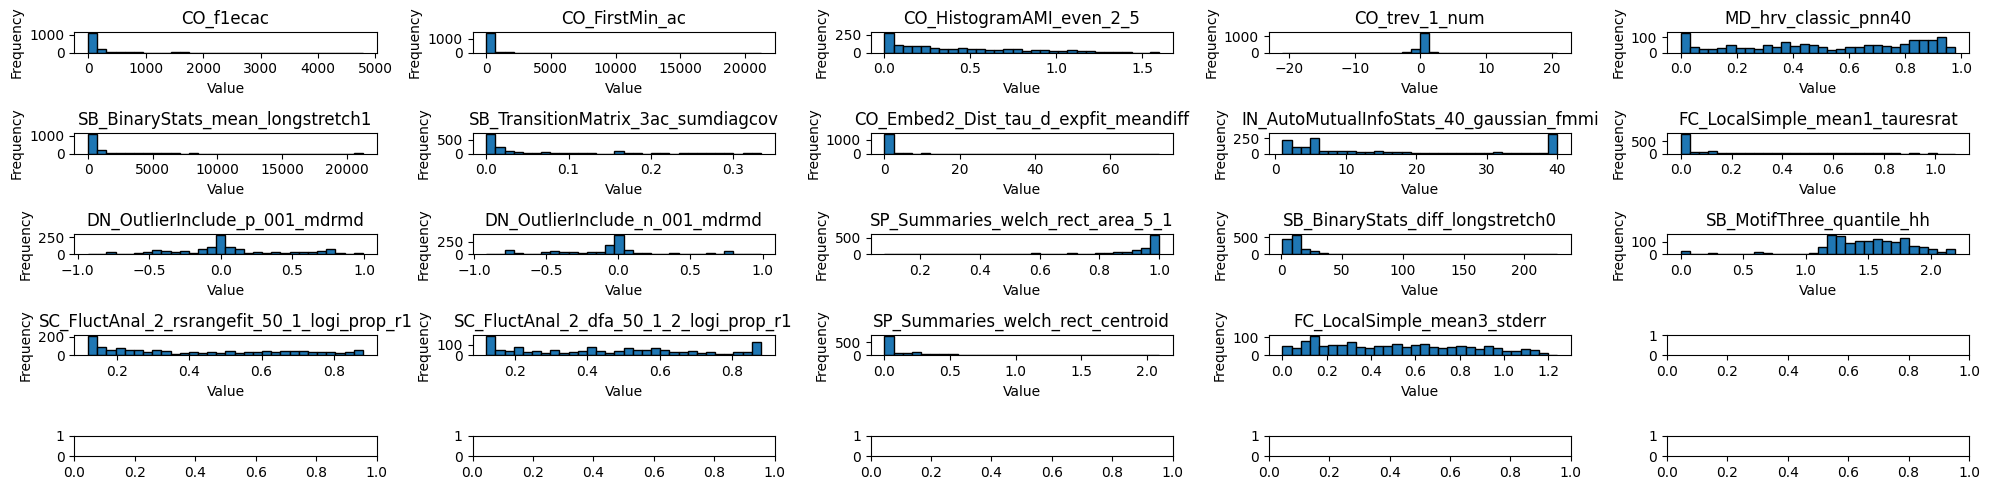

In [62]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import plotly.express as px

df = pd.read_csv(Path('out.csv'))
df = df.dropna()
df['Dataset'], _ = pd.factorize(df['Dataset'])

# Keep the 'File' column for hover information
# df = df.drop(columns=['Path'])

DROP_FEATURES = [
    'Dataset', 
    'Path',
    'File',
    'DN_Mean', 
    'DN_Spread_Std', 
    'DN_HistogramMode_5', 
    'DN_HistogramMode_10',
    # 'CO_Embed2_Dist_tau_d_expfit_meandiff', 
    'PD_PeriodicityWang_th0_01',
    # 'CO_FirstMin_ac',
    # 'CO_trev_1_num',
    # 'FC_LocalSimple_mean3_stderr',
]

feats = df.drop(columns=DROP_FEATURES)
feats_names = feats.columns

display(feats_names)

feats = feats.to_numpy()

fig, axs = plt.subplots(5, 5, figsize=(20, 5))

axs = axs.flatten()
for i in range(feats.shape[1]):
    axs[i].hist(feats[:, i], bins=30, edgecolor='black')
    axs[i].set_title(f'{feats_names[i]}')
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feats[:, 1:], feats[:, 0].astype(np.int64), test_size=0.1, random_state=42)

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

print("Score: ", rf.score(X_test, y_test))

importances = rf.feature_importances_

print(importances)

feature_importances = sorted(zip(importances, range(feats.shape[1]-1)), reverse=True)

# Select top K features
K = 15
top_features = [i for _, i in feature_importances[:K]]

print(list(zip(feats_names[top_features], top_features)))

filtered_feats = feats[:, top_features]
filtered_feats

Score:  0.5793103448275863
[0.04698796 0.06405469 0.04425903 0.04432612 0.04776077 0.0377659
 0.05017329 0.03651374 0.06164987 0.04120696 0.04219709 0.09037013
 0.03667173 0.0492157  0.03413784 0.03615945 0.12320594 0.11334378]
[('SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1', 16), ('SP_Summaries_welch_rect_centroid', 17), ('DN_OutlierInclude_n_001_mdrmd', 11), ('CO_FirstMin_ac', 1), ('IN_AutoMutualInfoStats_40_gaussian_fmmi', 8), ('SB_TransitionMatrix_3ac_sumdiagcov', 6), ('SB_BinaryStats_diff_longstretch0', 13), ('MD_hrv_classic_pnn40', 4), ('CO_f1ecac', 0), ('CO_trev_1_num', 3), ('CO_HistogramAMI_even_2_5', 2), ('DN_OutlierInclude_p_001_mdrmd', 10), ('FC_LocalSimple_mean1_tauresrat', 9), ('SB_BinaryStats_mean_longstretch1', 5), ('SP_Summaries_welch_rect_area_5_1', 12)]


array([[ 7.00000000e-01,  6.84347179e-01, -3.28125000e-02, ...,
         1.25000000e-01,  2.32800000e+03,  4.74302366e-01],
       [ 2.60000000e-01,  3.25779170e-01, -2.92013889e-02, ...,
         1.25470514e-03,  1.91200000e+03,  7.21631132e-01],
       [ 3.00000000e-01,  4.85313172e-01, -2.87500000e-02, ...,
         5.00000000e-01,  8.63000000e+02,  6.40413312e-01],
       ...,
       [ 4.58333333e-01,  3.06796158e-03, -7.52287122e-01, ...,
         1.91938580e-03,  7.27000000e+02,  9.76452208e-01],
       [ 7.50000000e-01,  2.45436926e-02, -6.78395496e-01, ...,
         8.19672131e-03,  1.76000000e+02,  9.25481269e-01],
       [ 4.79166667e-01,  1.84077695e-02, -5.64391274e-01, ...,
         3.83141762e-03,  1.54000000e+02,  9.83192743e-01]])

In [64]:
STANDARDIZE = 1
if STANDARDIZE: filtered_feats = StandardScaler().fit_transform(filtered_feats)
# if STANDARDIZE: feats = PCA(n_components=16).fit_transform(feats)

# Perform t-SNE
PERPLEXITY = 50

reducer = TSNE(n_components=2, init='pca', perplexity=PERPLEXITY, random_state=42)
embedding = reducer.fit_transform(filtered_feats)

# Create a new dataframe with the t-SNE results
tsne_df = pd.DataFrame(embedding, columns=['TSNE1', 'TSNE2'])
tsne_df['File'] = df['File']
tsne_df['Path'] = df['Path']
tsne_df['Dataset'] = df['Dataset']

# Create an interactive plot using plotly
fig = px.scatter(tsne_df, x='TSNE1', y='TSNE2', color='Dataset', 
                hover_data=['File'], 
                color_continuous_scale='Spectral',
                title='t-SNE Visualization')

fig.update_traces(marker=dict(size=6, opacity=0.7))
fig.update_layout(coloraxis_colorbar=dict(title='Dataset'))

fig.show()

display(tsne_df)
tsne_df.to_csv('embeddings.csv', index=False)

,TSNE1,TSNE2,File,Path,Dataset
0,25.259378,11.922157,S01R02E0.test.csv@1.out,data/raw/Daphnet/S01R02E0.test.csv@1.out,0.0
1,10.057662,-0.238655,S01R02E0.test.csv@4.out,data/raw/Daphnet/S01R02E0.test.csv@4.out,0.0
2,29.853590,-2.855373,S01R02E0.test.csv@6.out,data/raw/Daphnet/S01R02E0.test.csv@6.out,0.0
3,17.424347,14.931885,S02R01E0.test.csv@3.out,data/raw/Daphnet/S02R01E0.test.csv@3.out,0.0
4,19.279589,14.625178,S02R01E0.test.csv@4.out,data/raw/Daphnet/S02R01E0.test.csv@4.out,0.0
...,...,...,...,...,...
1444,-26.264004,-8.008312,Yahoo_A2synthetic_80_data.out,data/raw/YAHOO/Yahoo_A2synthetic_80_data.out,13.0
1445,-34.175423,10.345413,Yahoo_A2synthetic_81_data.out,data/raw/YAHOO/Yahoo_A2synthetic_81_data.out,13.0
1446,-32.881824,5.778555,Yahoo_A2synthetic_82_data.out,data/raw/YAHOO/Yahoo_A2synthetic_82_data.out,13.0
1447,-28.878117,16.604712,Yahoo_A2synthetic_83_data.out,data/raw/YAHOO/Yahoo_A2synthetic_83_data.out,13.0
